In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# Check if the current working directory is the notebooks directory
if 'notebooks' in os.path.basename(os.getcwd()):
    # Change directory to the parent of notebooks
    %cd ..
    print("Changed working directory to the project root:", os.getcwd())
else:
    print("Working directory:", os.getcwd())

Working directory: c:\Users\sghys\My Drive (sghyseli@student.ubc.ca)\ComputerVision


Shape of images: (50000, 32, 32, 3)
Shape of labels: 50000


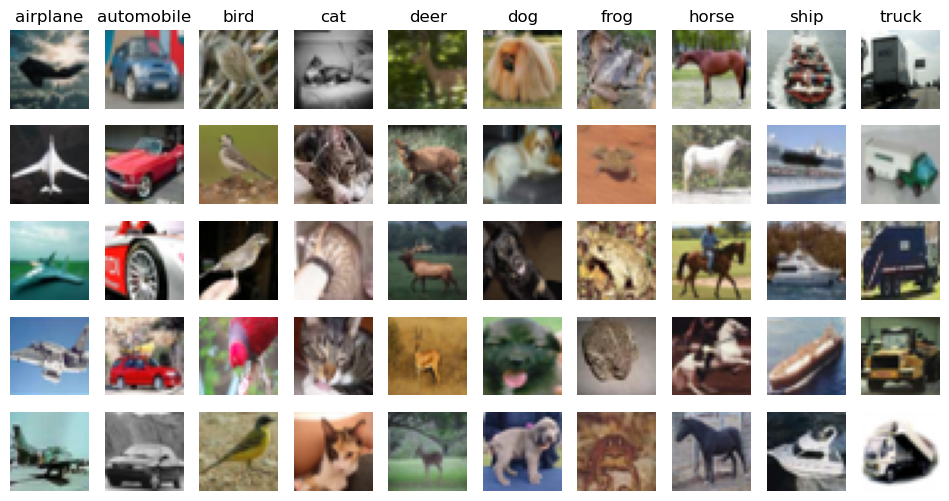

In [19]:
from utils.load_data import load_cifar10

data, labels, data_test, labels_test, label_names = load_cifar10()

# Reshaping the data to a more manageable format (10000, 32, 32, 3)
images = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
images_test = data_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Verifying the shape of images and labels
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {len(labels)}")

# Number of classes and number of samples per class to display
num_classes = 10
samples_per_class = 5

# show some examples of each class to make sure the data is correct
plt.figure(figsize=(12, 6))
for cls in range(num_classes):
    idxs = [i for i, lbl in enumerate(labels) if lbl == cls]
    random_idxs = random.sample(idxs, samples_per_class)
    
    for i, idx in enumerate(random_idxs):
        # Calculate the position of the subplot
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            # Label only the first row
            plt.title(label_names[cls])

plt.show()

# Build a CNN Model
Input: 3x32x32 RGB image
The np arrays need to be converted over to PyTorch tensors. The RGB color channel is shifted to second position to match the format for using nn.


PyTorch can use cuda on GPU if available. Tasks need to be specifcally sent to the GPU if it is going to be used for this purpose. The best way to do this is to determine the optimal hardware that is a available at runtime and send to that device.

In [20]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Reshaping the images from (N, 32, 32, 3) to (N, 3, 32, 32)
images_cnn = images.transpose(0, 3, 1, 2)
images_test_cnn = images_test.transpose(0, 3, 1, 2)

# Convert the numpy arrays to PyTorch tensors
X = torch.tensor(images_cnn, dtype=torch.float32)
X_test = torch.tensor(images_test_cnn, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.int8)
y_test = torch.tensor(labels_test, dtype=torch.int8)

print(f"Shape of images for CNN: {X.shape} {X.dtype}")
print(f"Shape of labels for CNN: {y.shape} {y.dtype}")

# Create tensor datasets
train_dataset = TensorDataset(X, y)
test_dataset = TensorDataset(X_test, y_test)

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Shape of images for CNN: torch.Size([50000, 3, 32, 32]) torch.float32
Shape of labels for CNN: torch.Size([50000]) torch.int8
Using cuda device


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


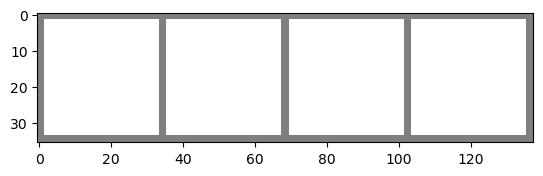

In [22]:
import torchvision 
import torchvision.transforms as transforms
from models.cnn import CNN

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract a batch of 4 images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)

model = CNN().to(device)
print(model)

